This notebook adds the column `'pm_prob'` to the `data-joined.fits` file, which are posterior probabilities of belonging to the "cluster" based on a mixture model in proper motions.

In [1]:
from os import path
import pickle

import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.wcs import WCS
import reproject

import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from scipy.spatial import cKDTree
from scipy.special import logsumexp
from scipy.optimize import minimize

from pyia import GaiaData
import gala.dynamics as gd
import gala.coordinates as gc
import gala.potential as gp
from gala.mpl_style import center_emph, center_deemph

import emcee

from helpers import fig_path, cluster_c

from xdgmm import XDGMM

from matplotlib.patches import Ellipse
from astroML.plotting.tools import draw_ellipse
from astroML.utils import log_multivariate_gaussian

In [2]:
orig_g = GaiaData('../data/data-joined.fits')
orig_g = orig_g[np.isfinite(orig_g.pmra) & np.isfinite(orig_g.pmdec)]

c = orig_g.get_skycoord(distance=False)
mag_c = c.transform_to(gc.MagellanicStream)

In [3]:
G0 = orig_g.G0
BPRP = orig_g.BP0 - orig_g.RP0

BPRP_err = np.sqrt((1/orig_g.phot_bp_mean_flux_over_error)**2 + 
                   (1/orig_g.phot_rp_mean_flux_over_error)**2)
G_err = 1 / orig_g.phot_g_mean_flux_over_error

bprp_mask = (BPRP < 0.35) & np.isfinite(BPRP)

/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [4]:
g = orig_g[bprp_mask]
c = g.get_skycoord(distance=False)
mag_c = c.transform_to(gc.MagellanicStream)

In [5]:
cluster_mag_c = cluster_c.transform_to(gc.MagellanicStream)

cluster_rad = 1.75 # deg
control_rad = cluster_rad / np.sqrt(2)

cluster_c.galactic, cluster_mag_c

(<SkyCoord (Galactic): (l, b) in deg
     ( 289.02118741,  32.62416777)>,
 <SkyCoord (MagellanicStream): (L, B) in deg
     ( 64.57506984, -12.87612597)>)

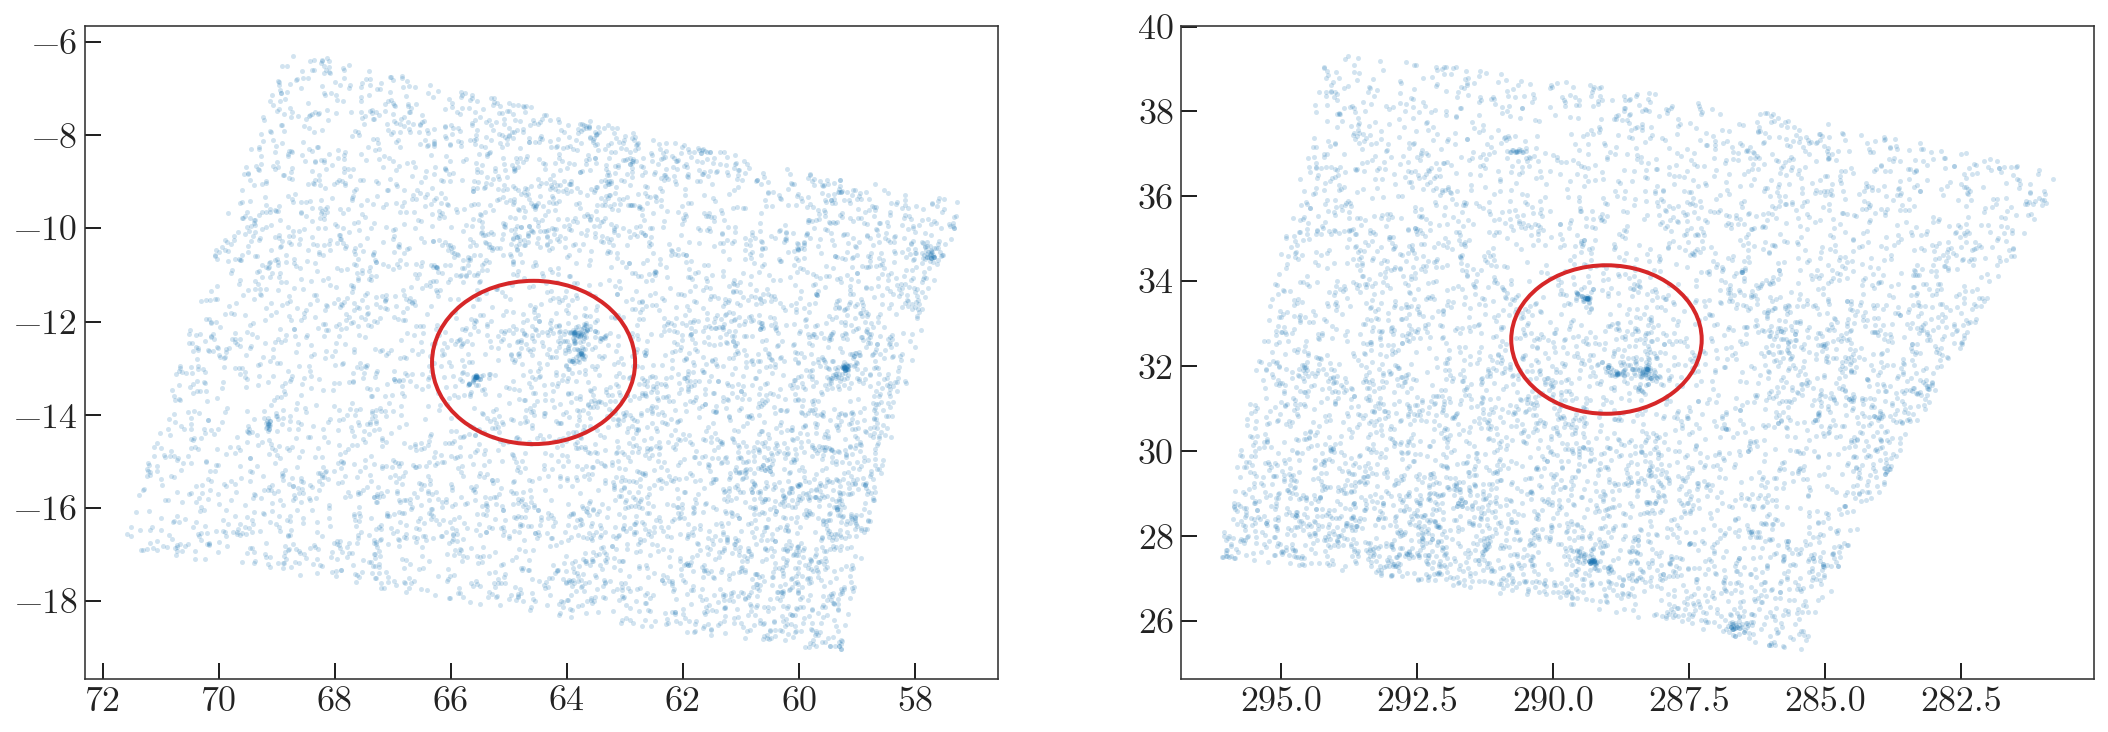

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

ax = axes[0]
ax.plot(mag_c.L, mag_c.B, marker='.', ls='none', alpha=0.2)
ax.add_patch(mpl.patches.Circle((cluster_mag_c.L.degree, cluster_mag_c.B.degree),
                                radius=cluster_rad, facecolor='none', 
                                edgecolor='tab:red', zorder=100, linewidth=2))
ax.invert_xaxis()

ax = axes[1]
ax.plot(mag_c.galactic.l, mag_c.galactic.b, 
        marker='.', ls='none', alpha=0.2)
ax.add_patch(mpl.patches.Circle((cluster_c.galactic.l.degree, 
                                 cluster_c.galactic.b.degree),
                                radius=cluster_rad, facecolor='none', 
                                edgecolor='tab:red', zorder=100, linewidth=2))
ax.invert_xaxis()

In [7]:
seed_locs = coord.SkyCoord(L=[cluster_mag_c.L.degree,
                              cluster_mag_c.L.degree]*u.deg,
                           B=[cluster_mag_c.B.degree + 3.5,
                              cluster_mag_c.B.degree - 3.5]*u.deg,
                           frame=gc.MagellanicStream)

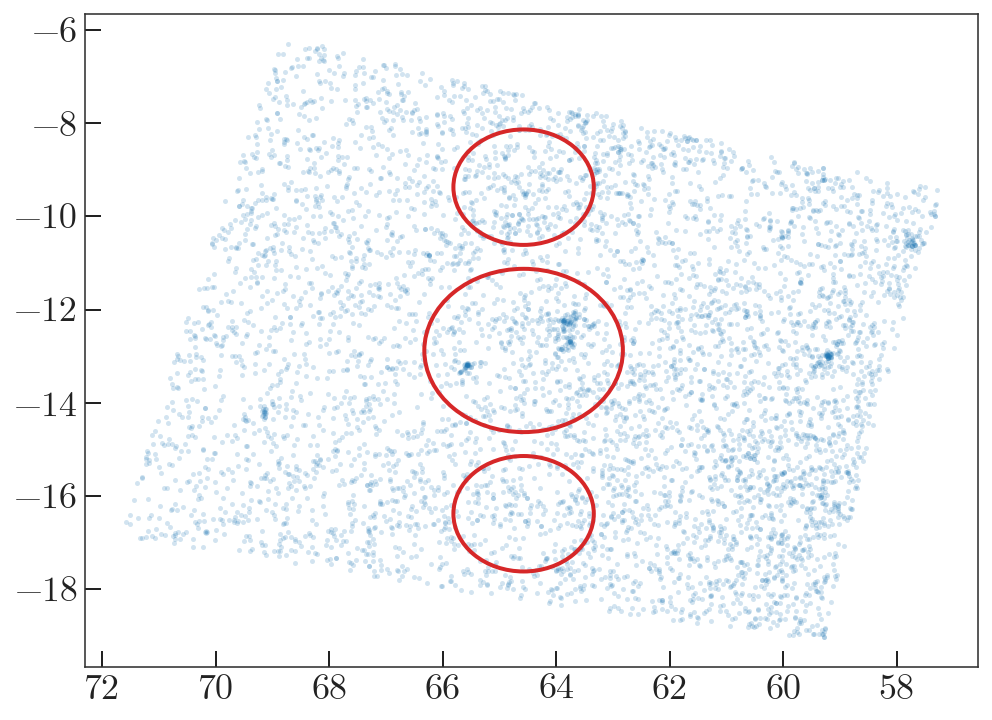

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(mag_c.L, mag_c.B, marker='.', ls='none', alpha=0.2)
ax.add_patch(mpl.patches.Circle((cluster_mag_c.L.degree, cluster_mag_c.B.degree),
                                radius=cluster_rad, facecolor='none', 
                                edgecolor='tab:red', zorder=100, linewidth=2))
ax.invert_xaxis()

for seed in seed_locs:
    ax.add_patch(mpl.patches.Circle((seed.L.degree, seed.B.degree),
                                     radius=control_rad, facecolor='none', 
                                     edgecolor='tab:red', zorder=100, linewidth=2))

In [9]:
control_mask = np.zeros(len(g)).astype(bool)
for seed in seed_locs:
    control_mask |= seed.separation(c) < control_rad*u.deg

In [10]:
cluster_mask = c.separation(cluster_c) < cluster_rad*u.deg

In [11]:
control_mask.sum(), cluster_mask.sum()

(480, 546)

In [12]:
if 'cluster_mask' not in orig_g.data.colnames:
    _cluster_mask = np.zeros(len(orig_g)).astype(bool)
    _cluster_mask[bprp_mask] = cluster_mask

    _control_mask = np.zeros(len(orig_g)).astype(bool)
    _control_mask[bprp_mask] = control_mask

    orig_g.data['cluster_mask'] = _cluster_mask
    orig_g.data['control_mask'] = _control_mask
    orig_g.data.write('../data/data-joined.fits', overwrite=True)

else:
    print('nothin to do here')

nothin to do here


In [13]:
X_co = np.vstack((g.pmra.value, g.pmdec.value)).T[control_mask]
X_cl = np.vstack((g.pmra.value, g.pmdec.value)).T[cluster_mask]

Cov_co = g[control_mask].get_cov()[:, 3:5, 3:5]
Cov_cl = g[cluster_mask].get_cov()[:, 3:5, 3:5]

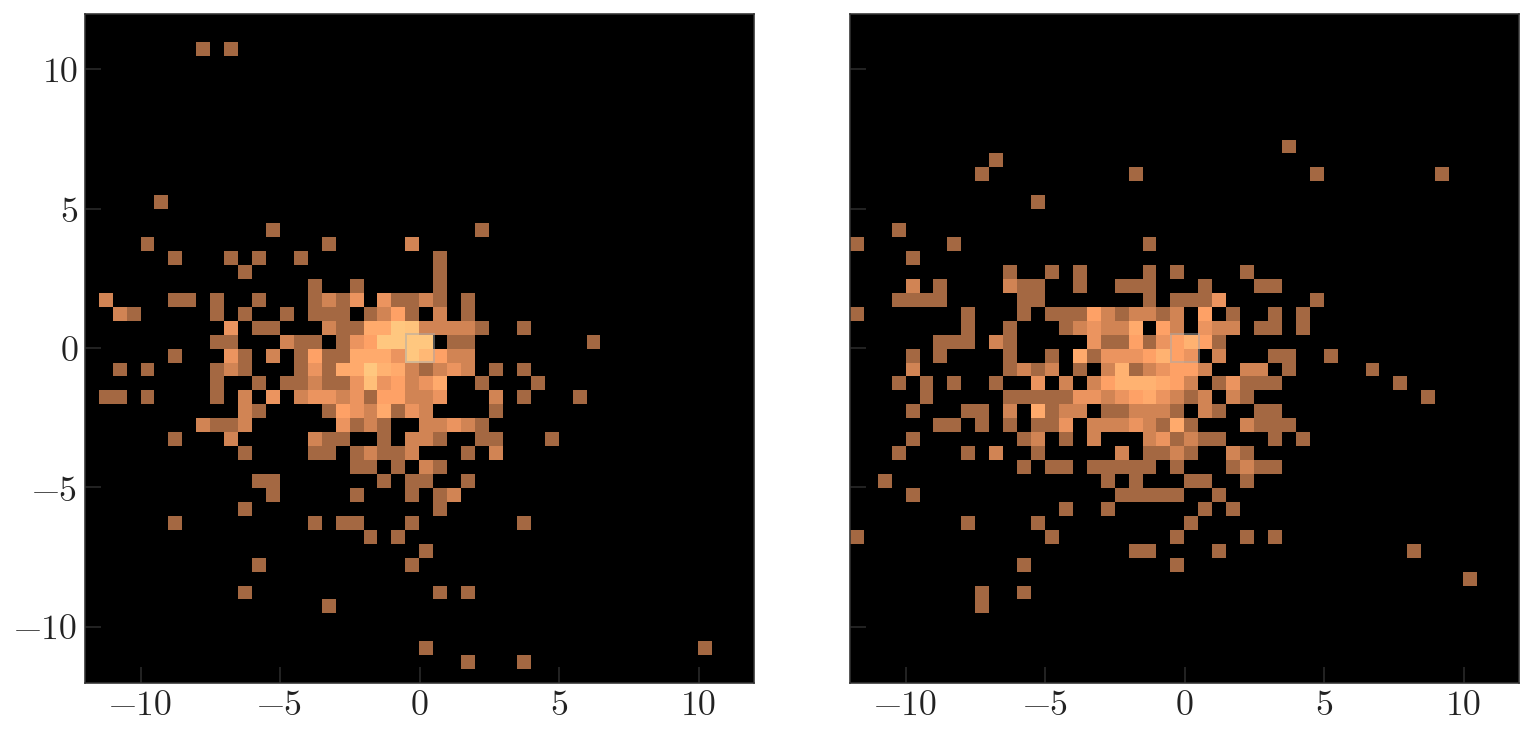

In [14]:
bins = np.arange(-12, 12+1e-3, 0.5)

H_cl, xe, ye = np.histogram2d(X_cl[:, 0], X_cl[:, 1],
                              bins=bins)

H_co, xe, ye = np.histogram2d(X_co[:, 0], X_co[:, 1],
                              bins=bins)

fig, axes = plt.subplots(1, 2, figsize=(11, 5), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

ax = axes[0]
ax.pcolormesh(xe, ye, H_cl.T + 0.1, cmap='copper', 
              norm=mpl.colors.LogNorm(vmin=0.1, vmax=10))

ax = axes[1]
ax.pcolormesh(xe, ye, H_co.T + 0.1, cmap='copper',
              norm=mpl.colors.LogNorm(vmin=0.1, vmax=10))


for ax in axes:
    ax.set_aspect('equal')
    ax.add_patch(mpl.patches.Rectangle((-0.5, -0.5), 1, 1,
                                       facecolor='none', edgecolor='#aaaaaa',
                                       alpha=0.5, zorder=100))

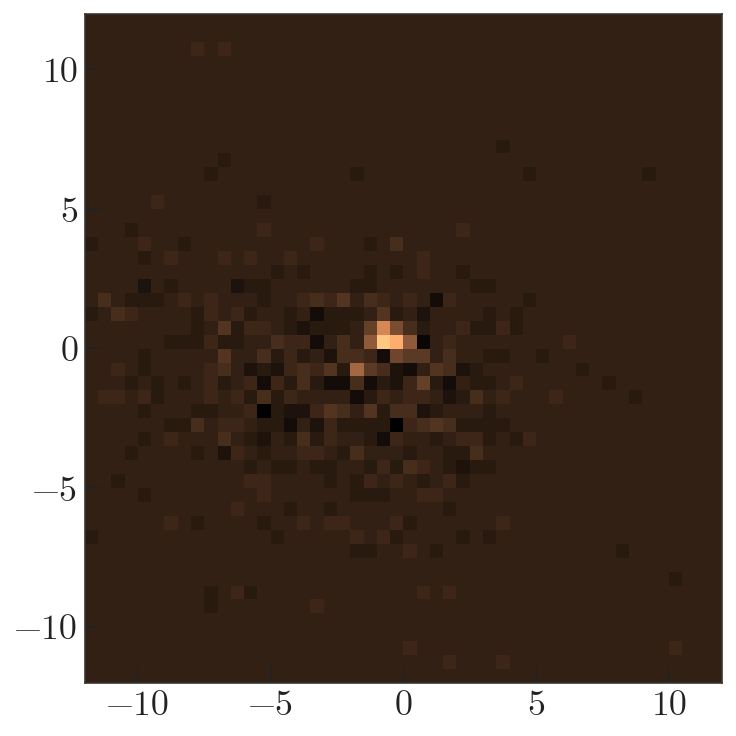

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), 
                       constrained_layout=True)
ax.pcolormesh(xe, ye, (H_cl - H_co).T, cmap='copper')

## Extreme deconvolution

First use heuristics to determine number of components:

In [16]:
# xdgmm = XDGMM()

# param_range = np.arange(1, 8+1, 1)

# # Loop over component numbers, fitting XDGMM model and computing the BIC:
# bic, optimal_n_comp, lowest_bic = xdgmm.bic_test(X_co, Cov_co, param_range)

# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.plot(param_range, bic, marker='', drawstyle='steps-mid')
optimal_n_comp = 3

In [17]:
gmm = XDGMM(n_components=optimal_n_comp, method='Bovy', 
            random_state=np.random.RandomState(42))
_ = gmm.fit(X_co, Cov_co)

(-20, 20)

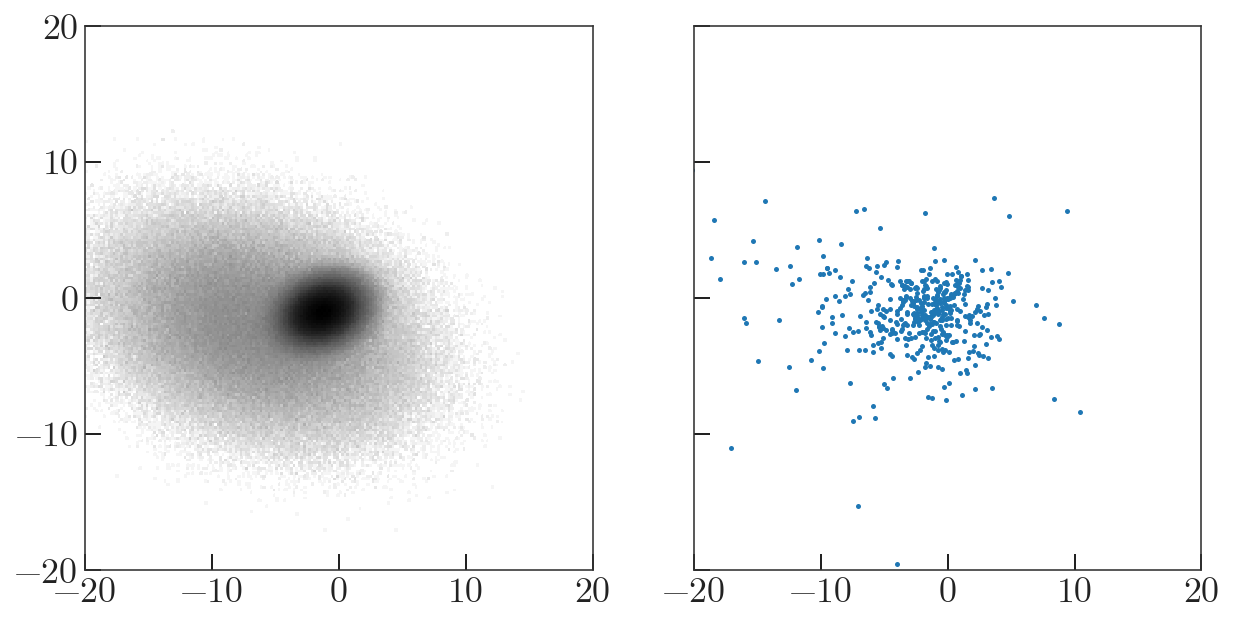

In [18]:
test = gmm.sample(size=1000000)
fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                         sharex=True, sharey=True)

ax = axes[0]
H_test, xe, ye = np.histogram2d(test[:, 0], test[:, 1], bins=np.arange(-20, 20+1e-3, 0.2))
ax.pcolormesh(xe, ye, H_test.T, norm=mpl.colors.LogNorm(), cmap='Greys')

ax = axes[1]
ax.plot(X_co[:, 0], X_co[:, 1], marker='.', ls='none', alpha=1)
# ax.plot(X_cl[:, 0], X_cl[:, 1], marker='.', ls='none', alpha=1)

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)

In [19]:
def ln_normal(x, mu, var):
    return -0.5*np.log(2*np.pi) - 0.5*np.log(var) - 0.5 * (x-mu)**2 / var

def ln_prior(p):
    x, y, lns, lnf = p
    
    lp = 0
    
    if x < -5 or x > 5 or y < -5 or y > 5:
        return -np.inf
    
    lp += ln_normal(lns, -1, 5)
    lp += -lnf
    
    return lp

def ln_likelihood(p, gmm, X, Cov):
    x, y, lns, lnf = p
    s = np.exp(lns)
    f = np.exp(lnf)
    
    mu = np.array([[x, y]])
    V = np.array([[[s, 0],
                   [0, s]]]) ** 2
    
    T = Cov + V
    logproba = log_multivariate_gaussian(X, mu, T)
    
    ll1 = logsumexp(gmm.logprob_a(X, Cov), axis=-1) + np.log(1-f)
    ll2 = logproba + np.log(f)
    
    return np.logaddexp(ll1, ll2).sum(), (ll1, ll2)

def ln_posterior(p, *args):
    lnp = ln_prior(p)
    if not np.isfinite(lnp):
        return -np.inf, None

    lnl, blob = ln_likelihood(p, *args)
    if not np.isfinite(lnl):
        return -np.inf, None

    return lnp + lnl, blob

In [20]:
faster_gmm = XDGMM(n_components=gmm.n_components, 
                   mu=gmm.mu, V=gmm.V, weights=gmm.weights, 
                   method='astroML')

In [24]:
filename = '../output/pm_membership_samples.pickle'

In [25]:
if not path.exists(filename):
    p0 = (-0.6, 0.3, np.log(0.2), np.log(0.1))
    res = minimize(lambda *args, **kwargs: -ln_likelihood(*args, **kwargs)[0],
                   x0=p0, args=(gmm, X_cl, Cov_cl), method='L-BFGS-B')
    print('done optimize', res)
    
    nwalkers = 32
    p0 = emcee.utils.sample_ball(res.x, [1e-3]*len(res.x), size=nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers, len(res.x), ln_posterior,
                                    args=(faster_gmm, X_cl, Cov_cl))
    
    pos, *_ = sampler.run_mcmc(p0, 256)
    print('done burn-in')
    sampler.reset()
    pos, prob, state, blobs = sampler.run_mcmc(pos, 256)
    
    sampler.lnprobfn = None
    with open(filename, 'wb') as f:
        pickle.dump((sampler, blobs), f)
    
else:
    with open(filename, 'rb') as f:
        sampler, blobs = pickle.load(f)

done optimize       fun: 2258.2098740248698
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00022737, -0.00513865, -0.00013642,  0.00027285])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 100
      nit: 17
   status: 0
  success: True
        x: array([-0.5539679 ,  0.44194604, -3.04214692, -1.44119341])
done burn-in


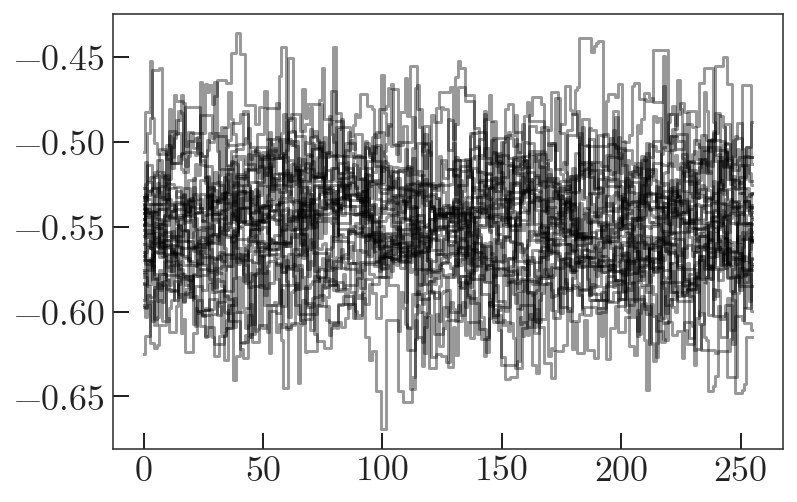

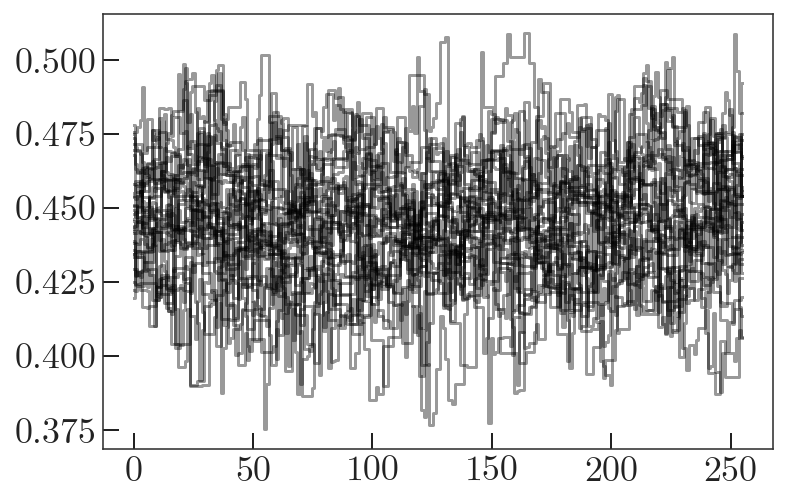

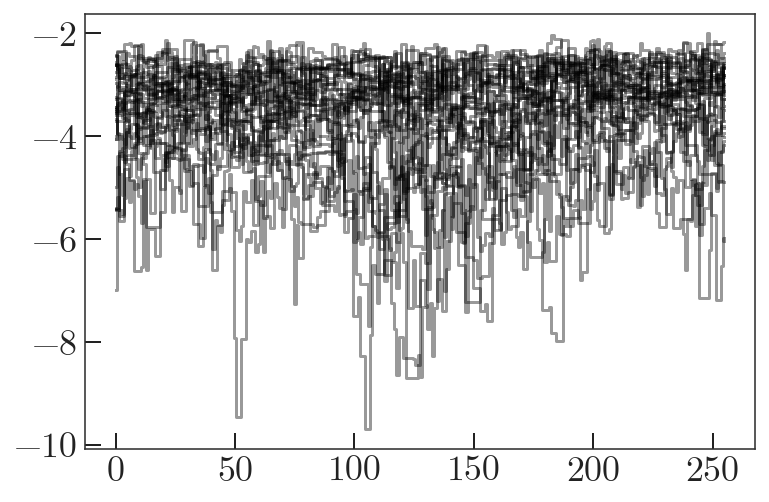

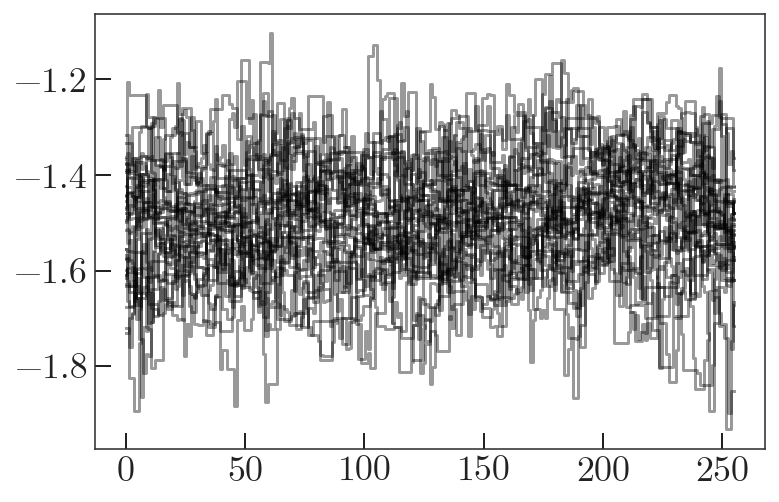

In [26]:
for k in range(sampler.chain.shape[-1]):
    plt.figure()
    for walker in sampler.chain[..., k]:
        plt.plot(walker, drawstyle='steps-mid', marker='', alpha=0.4, color='k')

In [27]:
norm = 0.0
post_prob = np.zeros(X_cl.shape[0])
for i in range(sampler.chain.shape[1]):
    for j in range(sampler.chain.shape[0]):
        ll_bg, ll_fg = sampler.blobs[i][j]
        post_prob += np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))
        norm += 1
post_prob /= norm

## Compute probabilities for all stars:

Note: this fucks up the variable definitions above

In [28]:
from tqdm import tqdm

In [29]:
all_X = np.vstack((orig_g.pmra.value, 
                   orig_g.pmdec.value)).T[bprp_mask]
all_V = orig_g.get_cov()[:, 3:5, 3:5][bprp_mask]
all_X.shape

(5983, 2)

In [33]:
if 'pm_prob' not in orig_g.data.colnames:
    chain = sampler.chain[::2, ::4]

    norm = 0.0
    all_post_prob = np.zeros(all_X.shape[0])
    for i in tqdm(range(chain.shape[1])):
        for j in range(chain.shape[0]):
            ll_bg, ll_fg = ln_likelihood(chain[j, i], gmm, all_X, all_V)[1]
            all_post_prob += np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))
            norm += 1
    all_post_prob /= norm
    
    prob = np.full(len(orig_g), np.nan)
    prob[bprp_mask] = all_post_prob
    orig_g.data['pm_prob'] = prob
    orig_g.data.write('../data/data-joined.fits', overwrite=True)
    
else:
    all_post_prob = orig_g.data['pm_prob'][bprp_mask]

Text(0.5,0,'prob.')

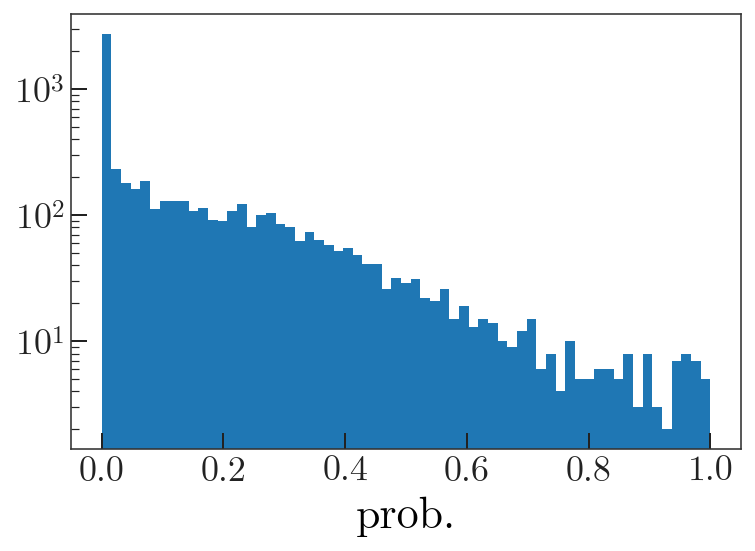

In [34]:
plt.hist(all_post_prob, bins=np.linspace(0, 1, 64));
plt.yscale('log')
plt.xlabel('prob.')

In [35]:
map_sample = sampler.flatchain[sampler.flatlnprobability.argmax()]
map_mu = map_sample[:2]
map_V = np.eye(2) * np.exp(map_sample[2])**2

### Many-panel figure

In [34]:
greens = plt.get_cmap('Greens')
greens.set_bad('w')

blues = plt.get_cmap('Blues')
blues.set_bad('w')

In [35]:
from gala.mpl_style import hesperia, laguna_r

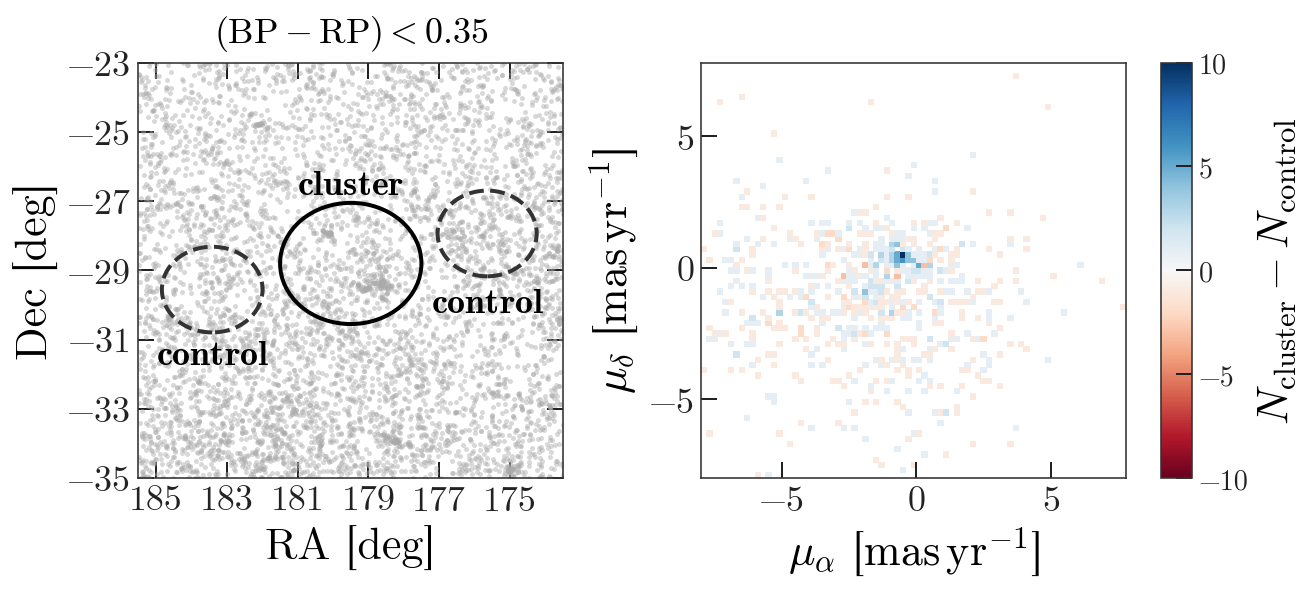

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4),
                         constrained_layout=True)

style = dict(marker='.', ls='none', mew=0)

# plot blue-selected stars
ax = axes[0]

ra = orig_g.ra[bprp_mask]
dec = orig_g.dec[bprp_mask]
ax.plot(ra, dec, alpha=0.45, color='#aaaaaa', **style)

ax.set_xlim(179.5+6, 179.5-6)
ax.set_ylim(-29-6, -29+6)

ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.set_xticks(np.arange(175, 185+1e-3, 2))
ax.set_yticks(np.arange(-35, -23+1e-3, 2))

ax.add_patch(Ellipse((cluster_c.ra.degree, cluster_c.dec.degree),
                       width=2*cluster_rad/np.cos(cluster_c.dec), 
                       height=2*cluster_rad,
                       facecolor='none', edgecolor='k', 
                       zorder=100, linewidth=2))

for i, seed in enumerate(seed_locs[::-1]):
    ax.add_patch(Ellipse((seed.icrs.ra.degree, seed.icrs.dec.degree),
                           width=2*control_rad / np.cos(seed.icrs.dec), 
                           height=2*control_rad,
                           facecolor='none', edgecolor='#333333', 
                           zorder=100, linewidth=2, linestyle='--'))
    
    ax.text(seed.icrs.ra.degree, -31. + i*1.5, r'${\bf control}$', 
            ha='center', va='top', fontsize=18)
    
ax.set_title(r'$({\rm BP} - {\rm RP}) < 0.35$', pad=10, fontsize=18)

ax.text(cluster_c.ra.degree, -27, r'${\bf cluster}$', 
        ha='center', va='bottom', fontsize=18)

# plot proper motions
ax = axes[1]

H_co, xe, ye = np.histogram2d(orig_g.pmra[bprp_mask][control_mask],
                              orig_g.pmdec[bprp_mask][control_mask],
                              bins=np.arange(-8, 8, 0.2))
H_cl, xe, ye = np.histogram2d(orig_g.pmra[bprp_mask][cluster_mask],
                              orig_g.pmdec[bprp_mask][cluster_mask],
                              bins=np.arange(-8, 8, 0.2))

ax.set_xlabel(r'$\mu_\alpha$ [{:latex_inline}]'.format(u.mas/u.yr))
ax.set_ylabel(r'$\mu_\delta$ [{:latex_inline}]'.format(u.mas/u.yr))

H = H_cl - H_co
H[H == 0] = np.nan
im = ax.pcolormesh(xe, ye, H.T,
                   cmap='RdBu',
                   vmin=-10, vmax=10, 
                   rasterized=True)

cb = fig.colorbar(im, ax=axes, aspect=30)
cb.set_label(r'$N_{\rm cluster} - N_{\rm control}$')
cb.set_ticks(np.arange(-10, 10+1e-3, 5))
cb.ax.tick_params(labelsize=14) 

fig.savefig(fig_path / 'pm-model.pdf', dpi=250)

In [37]:
prob_thresh = 0.5
print('N members in cluster field: {}'.format((cluster_mask & (all_post_prob > prob_thresh)).sum()))
print('N members in control field: {}'.format((control_mask & (all_post_prob > prob_thresh)).sum()))

N members in cluster field: 113
N members in control field: 29


In [38]:
# x, y, lns, lnf = p
flatchain = np.vstack(sampler.chain[:, 80:]).copy()
flatchain[:, 3] = np.exp(flatchain[:, 3])
med_flatchain = np.median(flatchain, axis=0)
std_flatchain = 1.5 * np.median(np.abs(flatchain - med_flatchain), axis=0)

In [39]:
med_flatchain

array([-0.54850276,  0.44510112, -3.2561217 ,  0.22689132])

In [40]:
std_flatchain

array([ 0.03250235,  0.02028774,  0.77381857,  0.02504608])

In [41]:
np.percentile(np.exp(flatchain[:, 2]), [5, 95])

array([ 0.00339519,  0.08555056])

### CMD of high probability members

In [42]:
prob_thresh = 0.5

In [97]:
DM = coord.Distance(25*u.kpc).distmod.value

isos = []
ages = [7.6, 7.8, 8]
for age in ages:
    iso = Table.read('/Users/adrian/data/Isochrones/MIST/FeH_-1.2_iso.fits')
    iso = iso[iso['log10_isochrone_age_yr'] == age]
    iso = iso[iso['phase'] == 0]
    isos.append(iso)

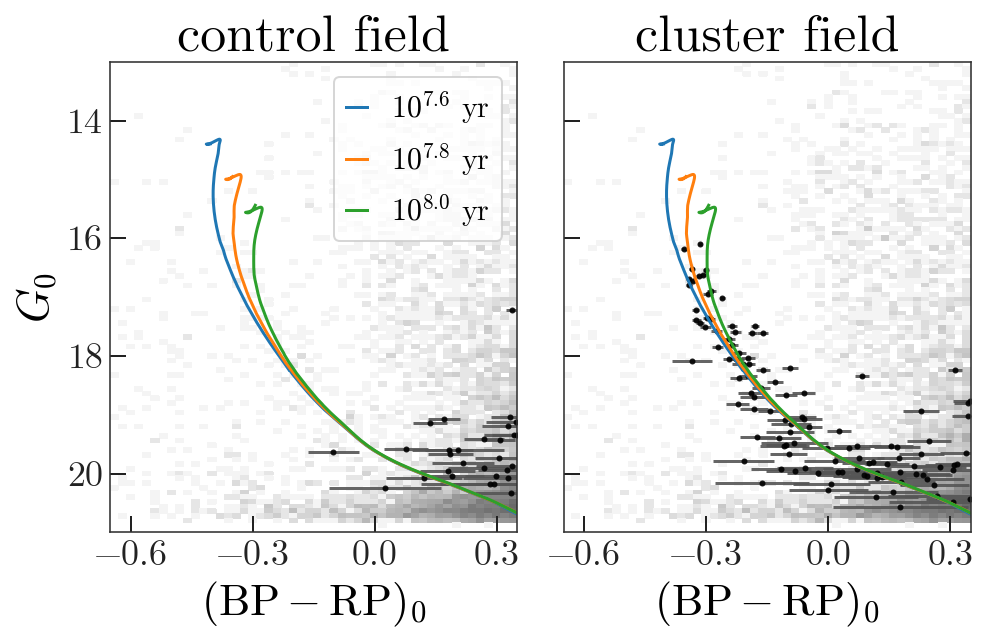

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4.6), 
                         sharex=True, sharey=True)

H_bg, xe, ye = np.histogram2d(BPRP[bprp_mask],
                              G0[bprp_mask],
                              bins=(np.arange(-0.65, 0.35+1e-3, 0.02),
                                    np.arange(13, 21+1e-3, 0.08)))

for j, mask in enumerate([control_mask, cluster_mask]):
    ax = axes[j]
    
    ax.pcolormesh(xe, ye, H_bg.T, zorder=-100, 
                  cmap='Greys', norm=mpl.colors.LogNorm(vmin=0.5, vmax=1e3), 
                  rasterized=True, linewidth=0, label=None)
    
    ax.plot(np.array(BPRP[bprp_mask][mask & (all_post_prob > prob_thresh)]),
            np.array(G0[bprp_mask][mask & (all_post_prob > prob_thresh)]),
            marker='o', ms=3, ls='none', color='k', alpha=0.9, label=None)
    
    ax.errorbar(BPRP[bprp_mask][mask & (all_post_prob > prob_thresh)],
                G0[bprp_mask][mask & (all_post_prob > prob_thresh)],
                xerr=BPRP_err[bprp_mask][mask & (all_post_prob > prob_thresh)],
                yerr=G_err[bprp_mask][mask & (all_post_prob > prob_thresh)],
                marker='', ls='none', ecolor='#555555', alpha=0.9, label=None)
    
    for iso, age in zip(isos, ages):
        if j == 0:
            label = r'$10^{{{:.1f}}}$ yr'.format(age)
        else:
            label = None
            
        ax.plot(iso['G_BP']-iso['G_RP'], iso['G'] + DM,
                marker='', label=label)

    ax.set_xlabel(r'$({\rm BP}-{\rm RP})_0$')
    ax.xaxis.set_ticks(np.arange(-0.6, 0.3+1e-3, 0.3))
    ax.set_xlim(-0.65, 0.35)
    ax.set_ylim(21, 13)

axes[0].legend(fontsize=15, handlelength=0.7)
axes[0].set_ylabel(r'$G_0$')
axes[0].set_title('control field')
axes[1].set_title('cluster field')

fig.tight_layout()
fig.savefig(fig_path / 'pm-members-cmd.pdf', dpi=250)